In this notebook, we will explore the influence of r/WallStreeBets on the stock market. In 2021, uprecedented spikes in stocks like GameStop and AMC occured, with credit attributed to the small community of r/WallStreetBets. Their collective efforts and motivation turned the investment world upside down temporarily, resulting in many news headlines, a super bowl ad, and a vision for future of investing for the little guy.

For this experiment, we'll look at the most frequently mentioned stocks on r/WallStreetBets and look for any correlation with their stock performance.

Prerequisites:

1. Access to Beneath API for reddit data: https://about.beneath.dev/
2. Access to Alpha Vantage API for stock data: https://www.alphavantage.co/

There are two aspects of accumulating data:

1. Scraping r/WallStreetBets posts for stocks that have the hightest mention count
2. Aggregating the historical stock data for each of the r/WallStreetBets stocks



In [105]:
import calendar
import time
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import calendar
import beneath as b
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

np.random.seed(42)

In [2]:
# retrieve API keys
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)
        
filename = 'apikey'
key = get_file_contents(filename)

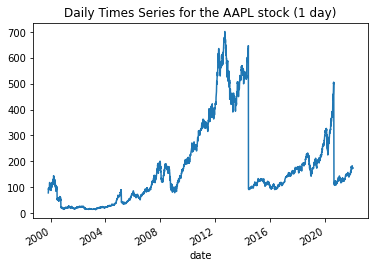

In [3]:
# alpha_vantage is a nice API for collecting historic stock data 
# we'll take a peek at the historic Apple (AAPL) price


ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

data['4. close'].plot()
plt.title('Daily Times Series for the AAPL stock (1 day)')
plt.show()

In [4]:
months =  { 
    "January":   1,
    "February":  2,
    "March":     3,
    "April":     4,
    "May":       5,
    "June":      6,
    "July":      7,
    "August":    8,
    "September": 9,
    "October":  10,
    "November": 11,
    "December": 12
}

def get_month_id(m):
    return months[m]

def encode_months(timestamps):
    # Column will be of type str if the dataframe is loaded from csv
    if type(timestamps[0]) == str:
        return timestamps.apply(lambda x: get_month_id(datetime.datetime.fromisoformat(x).strftime("%B")))
    # Column will be of type datetime if the dataframe is queried from beneath API
    else:
        return timestamps.apply(lambda x: get_month_id(x.month_name()))
    
def get_days_in_months(month):
    month_val = months[month]
    return calendar.monthrange(2021, month_val)[1]

def get_month_avg(month, df, year='2021', mtd=False):
    month_sum = 0
    if mtd:
        days_in_month = datetime.datetime.today().day # if the month is not finished, we get month-to-date days
    else:
        days_in_month = get_days_in_months(month)
    
    for day in range(1, days_in_month+1):
        try:
            daily_high = float(df.loc[f'{year}-{months[month]}-{day}']['2. high'])
            daily_low = float(df.loc[f'{year}-{months[month]}-{day}']['3. low'])
            daily_avg = (daily_high + daily_low) / 2
            month_sum += daily_avg
        except TypeError:
            days_in_month-=1 # The market was closed on this date (no data points), so we take 1 day off days_in_month
            
            if days_in_month == 0: # Possible if a stock has its IPO mid-year, and therefore will have no data for some months
                return 0 
            
            continue
        
#     print(f'{month} average ({month_sum}/{days_in_month}): {month_sum / days_in_month}')
    
    return month_sum / days_in_month # month average for the stock

def get_pct_change(previous, current):
    if current == previous:
        return 0
    try:
        return ((current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return float(0) # This would mathematically be infinity, but in context it means a stock recently IPO'd

def get_pct_increases(df):
    highs = []
    pct_changes = []
    
    for m in months.keys():
        highs.append(get_month_avg(m, df))
    highs.append(get_month_avg('January', df, year='2022', mtd=True)) # January 2022 (TODO: mtd=False starting in Feb)
    
    for i in range(1,len(highs)):
        curr_month_avg = highs[i]
        prev_month_avg = highs[i-1]
        
        pct_changes.append(get_pct_change(prev_month_avg, curr_month_avg))
    
    return pct_changes

def get_stock_pct_changes(stock):
    print(stock)
    df, _ = ts.get_daily(symbol=stock, outputsize='full')
    
    
    return get_pct_increases(df)

def get_top_N_stocks(df, N=10):
    # These symbols (stocks) are the top N most frequently mentioned along with post count
    top_N_stonks = dict(df.symbol.value_counts()[:N])

    # Drop rows from dataframe df if the symbol is not in top_stonks
    symbol_names_N = list(top_N_stonks.keys())
    df_top_N = df[df.symbol.isin(symbol_names_N)].sort_values(by=['symbol', 'month'])
    df_top_N = df_top_N[df_top_N['month'] > 2]
    
    return top_N_stonks, df_top_N

def get_stock_pcts_and_mentions(top_N, df_top_N):
    wsb_data = {}
    percentages = []
    
    # For every symbol in the top N stocks, get the monthly average stock prices and their monthy r/WallStreeBets mention count
    for symbol in list(top_N.keys()):
        stock_data = {}
        stock_data['pcts'] = get_stock_pct_changes(symbol) # API call happens here
        
        stock_mentions = []
        stock = df_top_N.loc[df_top_N.symbol == symbol]
        
        for month in months.values():
            stock_mentions.append(len(stock.loc[df_top_N['month'] == month]))
        
        stock_data['mentions'] = stock_mentions

        wsb_data[symbol] = stock_data
        
        time.sleep(15) # Free tier API calls are limited to 5 per minute
    
    return wsb_data

In [5]:
# This filter will get post data for 2021 plus January 2022
_filter = '{ "num_unique_symbols_title": "1", "timestamp": { "_gte": "2021-01-01", "_lt": "2022-01-31" } }'

In [6]:
# # beneath client for accessing table, uncomment to access the API (be careful; free tier is metered)

# client = b.Client()
# table = await client.find_table("examples/wallstreetbets-analytics/r-wallstreetbets-posts-stock-mentions")
# # cursor = await table.primary_instance.query_index(filter=_filter)
# cursor = await table.primary_instance.query_index()
# record = await cursor.read_all(to_dataframe=True)
# # record.to_csv('csv/r-wallstreetbets-posts-stock-mentions.csv')

In [7]:
record = pd.read_csv('csv/r-wallstreetbets-posts-stock-mentions.csv')
month_encoded = encode_months(record['timestamp'])
df = record.drop(columns=['@meta.timestamp', 'post_id','author','timestamp','Unnamed: 0'])
df.insert(loc=0, column='month', value=month_encoded)

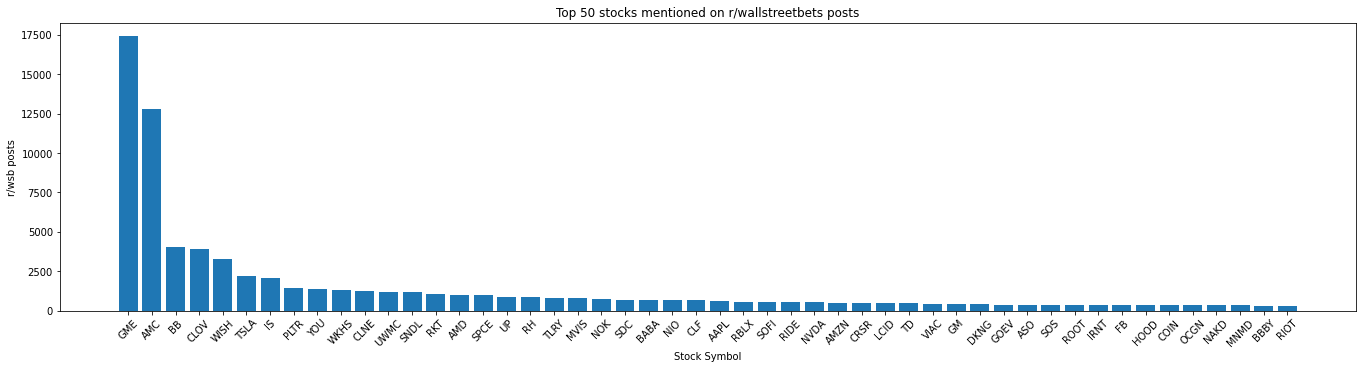

In [8]:
top_N_stonks, df_top_N = get_top_N_stocks(df, N=50)

# We can look at the top 50 stocks mentioned on r/wallstreetbets
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
symbols = list(top_N_stonks.keys())
posts = list(top_N_stonks.values())
ax.bar(symbols, posts)
plt.xlabel("Stock Symbol")
plt.ylabel("r/wsb posts")
plt.title('Top 50 stocks mentioned on r/wallstreetbets posts')
plt.xticks(rotation = 45)
plt.show()

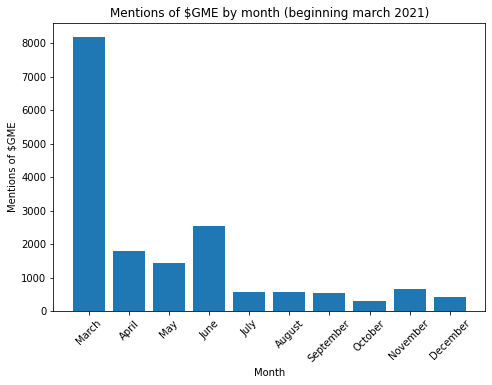

In [9]:
# Let's take a look at mentions of GameStop (GME) by month from March 2021 to Dec 2021
gme_mentions = []

gme = df_top_N.loc[df_top_N['symbol'] == 'GME']
for month in months.values():
    gme_mentions.append(len(gme.loc[df_top_N['month'] == month]))
    
# There is no January or February data from this dataset. We will remove the Jan/Feb index as well
# So index 0 of gme_mentions corresponds to March 2021. (beneath started recording data from March 9, 2021)
gme_mentions = gme_mentions[2:]

# Viz
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(months.keys())[2:], gme_mentions)
plt.xlabel("Month")
plt.ylabel("Mentions of $GME")
plt.title('Mentions of $GME by month (beginning march 2021)')
plt.xticks(rotation = 45)
plt.show()

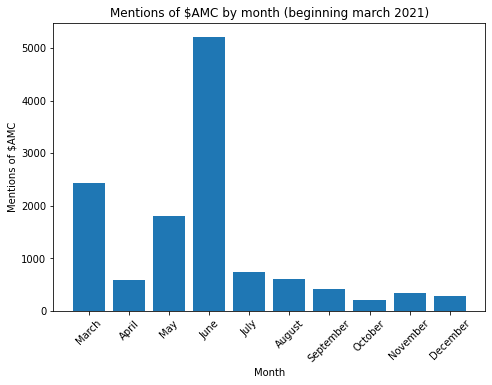

In [10]:
# Let's now take a look at mentions of AMC by month from March 2021 to Dec 2021
amc_mentions = []

amc = df_top_N.loc[df_top_N['symbol'] == 'AMC']
for month in months.values():
    amc_mentions.append(len(amc.loc[df_top_N['month'] == month]))
    
# There is no January or February data from this dataset. We will remove the Jan/Feb index as well
# So index 0 of gme_mentions corresponds to March 2021. (beneath started recording data from March 9, 2021)
amc_mentions = amc_mentions[2:]

# Viz
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(months.keys())[2:], amc_mentions)
plt.xlabel("Month")
plt.ylabel("Mentions of $AMC")
plt.title('Mentions of $AMC by month (beginning march 2021)')
plt.xticks(rotation = 45)
plt.show()

In [11]:
%%time

# Sum all data by month and create our complete dataframe
top_N, df_N = get_top_N_stocks(df, N=45)
wsb_data = get_stock_pcts_and_mentions(top_N, df_N)

GME
January average (1584.3102500000002/19): 83.38475000000001
February average (1502.2650499999997/19): 79.06658157894735
March average (4350.08795/23): 189.13425869565216
April average (3497.45745/21): 166.54559285714285
May average (3545.74645/20): 177.28732250000002
June average (5209.55385/22): 236.79790227272727
July average (3829.13505/21): 182.33976428571427
August average (3778.8813/22): 171.76733181818182
September average (4126.880400000001/21): 196.51811428571432
October average (3753.528350000001/21): 178.73944523809527
November average (4454.147/21): 212.10223809523808
December average (3482.6054500000005/22): 158.30024772727276
January average (1349.2201/10): 134.92201
AMC
January average (84.038/19): 4.423052631578948
February average (138.54505/19): 7.291844736842106
March average (246.325/23): 10.709782608695651
April average (209.65654999999998/21): 9.983645238095237
May average (270.25714999999997/20): 13.512857499999999
June average (1190.99235/22): 54.136015909090

August average (16.93775/22): 0.7698977272727273
September average (15.210149999999999/21): 0.7242928571428571
October average (14.012699999999999/21): 0.6672714285714285
November average (14.952850000000002/21): 0.7120404761904763
December average (13.171050000000003/22): 0.598684090909091
January average (5.9601999999999995/10): 0.59602
RKT
January average (391.78774999999996/19): 20.62040789473684
February average (398.40325/19): 20.96859210526316
March average (586.9331999999998/23): 25.51883478260869
April average (471.21845/21): 22.43897380952381
May average (364.8449/20): 18.242245
June average (441.00174999999996/22): 20.04553409090909
July average (376.0149/21): 17.905471428571428
August average (391.26435/22): 17.784743181818182
September average (354.00640000000004/21): 16.857447619047623
October average (337.13345000000004/21): 16.05397380952381
November average (344.22855000000004/21): 16.391835714285715
December average (339.8405/22): 15.447295454545456
January average (1

July average (457.1456999999999/21): 21.768842857142854
August average (537.18315/22): 24.417415909090906
September average (462.83215000000007/21): 22.039626190476195
October average (463.0088000000001/21): 22.048038095238102
November average (467.60965/21): 22.26712619047619
December average (450.7287999999999/22): 20.487672727272724
January average (227.90749999999997/10): 22.790749999999996
AAPL
January average (2527.4678499999995/19): 133.0246236842105
February average (2498.4613/19): 131.49796315789473
March average (2804.56945/23): 121.93780217391304
April average (2765.4501/21): 131.6881
May average (2539.8140500000004/20): 126.99070250000003
June average (2853.5441/22): 129.70655
July average (3042.7973/21): 144.89510952380954
August average (3257.0097/22): 148.04589545454544
September average (3120.7620999999995/21): 148.607719047619
October average (3048.9156/21): 145.18645714285714
November average (3235.00005/21): 154.04762142857143
December average (3815.7352999999994/22)

June average (1119.64065/22): 50.89275681818182
July average (1016.0552/21): 48.38358095238095
August average (1174.7547000000002/22): 53.39794090909092
September average (1203.8331999999998/21): 57.325390476190464
October average (1026.7265/21): 48.8917380952381
November average (849.8125000000001/21): 40.46726190476191
December average (647.86585/22): 29.44844772727273
January average (260.0065/10): 26.00065
GOEV
January average (304.75879999999995/19): 16.03993684210526
February average (300.71085/19): 15.826886842105262
March average (307.4343/23): 13.366708695652175
April average (186.99175/21): 8.904369047619047
May average (154.57375000000002/20): 7.728687500000001
June average (212.95135000000002/22): 9.679606818181819
July average (182.3496/21): 8.683314285714285
August average (161.85389999999998/22): 7.356995454545454
September average (154.61214999999996/21): 7.362483333333332
October average (150.49550000000002/21): 7.166452380952382
November average (204.34095/21): 9.7305

In [12]:
column_names = ['symbol', 
                'month', 
                'month_idx', 
                'num_mentions_title', 
                'num_mentions_body', 
                'num_unique_symbols_title', 
                'num_unique_symbols_body', 
                'length_title', 
                'length_body']

aggregate_df = pd.DataFrame(columns = column_names)

for symbol in wsb_data.keys():
    for month in list(months.keys())[2:]:
        # r/WallStreetBets post data
        series = df_N[(df_N.symbol == symbol) & (df_N.month == months[month])].sum(axis='rows', numeric_only=True)[1:]
        series = pd.Series([symbol, month, months[month]], ['symbol', 'month', 'month_idx']).append(series)
        
        # r/WallStreetBets mentions
        series = pd.Series([wsb_data[symbol]['mentions'][months[month]-1]], ['num_unique_posts']).append(series)
        
        # Percent increase/decrease of the monthly stock price since the previous month
        series = pd.Series([wsb_data[symbol]['pcts'][months[month]-1]], ['next_month_price_pct_change']).append(series)

        aggregate_df = aggregate_df.append(series, ignore_index=True)

In [13]:
aggregate_df.head()

,symbol,month,month_idx,num_mentions_title,num_mentions_body,num_unique_symbols_title,num_unique_symbols_body,length_title,length_body,next_month_price_pct_change,num_unique_posts
0,GME,March,3,6267,7603,7740,6068,501076,4266636,-11.943191,8192.0
1,GME,April,4,1306,1533,1728,1782,115990,1245433,6.449723,1806.0
2,GME,May,5,1004,1084,1608,1578,86756,925648,33.567307,1434.0
3,GME,June,6,1035,2803,3117,6408,143200,2519496,-22.997728,2526.0
4,GME,July,7,276,589,664,1188,33479,677215,-5.798205,573.0


In [14]:
aggregate_df.to_csv('csv/aggregate_data.csv')

In [15]:
aggregate_df

,symbol,month,month_idx,num_mentions_title,num_mentions_body,num_unique_symbols_title,num_unique_symbols_body,length_title,length_body,next_month_price_pct_change,num_unique_posts
0,GME,March,3,6267,7603,7740,6068,501076,4266636,-11.943191,8192.0
1,GME,April,4,1306,1533,1728,1782,115990,1245433,6.449723,1806.0
2,GME,May,5,1004,1084,1608,1578,86756,925648,33.567307,1434.0
3,GME,June,6,1035,2803,3117,6408,143200,2519496,-22.997728,2526.0
4,GME,July,7,276,589,664,1188,33479,677215,-5.798205,573.0
...,...,...,...,...,...,...,...,...,...,...,...
445,COIN,August,8,21,36,26,37,1388,19313,-3.678228,28.0
446,COIN,September,9,8,7,10,48,866,7839,12.444202,11.0
447,COIN,October,10,22,15,33,259,1868,14335,19.970649,30.0
448,COIN,November,11,28,46,40,430,1772,36943,-20.969625,40.0


In [96]:
train_ratio = round(0.75 * aggregate_df.shape[0])

_X = aggregate_df.drop(columns=['symbol', 'month', 'next_month_price_pct_change']).to_numpy()
X = _X / _X.max(axis=0)

_y = aggregate_df['next_month_price_pct_change'].to_numpy()
y = np.where(_y > 0, 1, -1).astype('int')

X_train_demo = X[:train_ratio]
y_train_demo = y[:train_ratio]

X_test_demo = X[train_ratio:]
y_test_demo = y[train_ratio:]

clf = GradientBoostingClassifier(learning_rate=0.0001, n_estimators=10000, max_depth=4)
clf.fit(X_train_demo, y_train_demo)

y_pred_demo = clf.predict(X_test_demo)
accuracy_score(y_test_demo, y_pred_demo)

0.7321428571428571

In [98]:
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [111]:
# Tuning!
learning_rates = [0.1, 0.001, 0.0001, 0.00001]
estimators = [100, 1000, 10000]
depths = [3, 4, 5]

In [99]:
X_train, y_train = unison_shuffled_copies(X[:train_ratio], y[:train_ratio])
X_test, y_test = unison_shuffled_copies(X[train_ratio:], y[train_ratio:])

In [110]:
%%time

peak_acc_gb = 0.0
clfs = {}

for n_est in estimators:
    for depth in depths:
        clfs[f'{lr}_{n_est}_{depth}'] = {}

        clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)

        clfs[f'{lr}_{n_est}_{depth}']['clf'] = clf
        clfs[f'{lr}_{n_est}_{depth}']['preds'] = y_pred
        clfs[f'{lr}_{n_est}_{depth}']['acc'] = score

        if score > peak_acc_gb:
            peak_acc_gb = score
            print(f'estimators: {n_est}, depth: {depth}, score: {score} (new peak accuracy)')
        else:
            print(f'estimators: {n_est}, depth: {depth}, score: {score}')

estimators: 100, depth: 3, score: 0.6607142857142857 (new peak accuracy)
estimators: 100, depth: 4, score: 0.6428571428571429
estimators: 100, depth: 5, score: 0.6160714285714286
estimators: 1000, depth: 3, score: 0.6696428571428571 (new peak accuracy)
estimators: 1000, depth: 4, score: 0.6428571428571429
estimators: 1000, depth: 5, score: 0.6339285714285714
estimators: 10000, depth: 3, score: 0.6607142857142857
estimators: 10000, depth: 4, score: 0.6428571428571429
estimators: 10000, depth: 5, score: 0.6339285714285714
estimators: 100000, depth: 3, score: 0.6607142857142857
estimators: 100000, depth: 4, score: 0.6517857142857143
estimators: 100000, depth: 5, score: 0.6339285714285714
CPU times: user 6min 29s, sys: 4.85 s, total: 6min 34s
Wall time: 6min 37s


In [112]:
%%time

peak_acc_gb = 0.0
clfs = {}

for lr in learning_rates:
    for n_est in estimators:
        for depth in depths:
            clfs[f'{lr}_{n_est}_{depth}'] = {}
            
            clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_est, max_depth=depth)
            clf.fit(X_train, y_train)
            
            y_pred = clf.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            
            clfs[f'{lr}_{n_est}_{depth}']['clf'] = clf
            clfs[f'{lr}_{n_est}_{depth}']['preds'] = y_pred
            clfs[f'{lr}_{n_est}_{depth}']['acc'] = score
            
            if score > peak_acc_gb:
                peak_acc_gb = score
                print(f'lr: {lr}, estimators: {n_est}, depth: {depth}, score: {score} (new peak accuracy)')
            else:
                print(f'lr: {lr}, estimators: {n_est}, depth: {depth}, score: {score}')

lr: 0.1, estimators: 100, depth: 3, score: 0.6160714285714286 (new peak accuracy)
lr: 0.1, estimators: 100, depth: 4, score: 0.6160714285714286
lr: 0.1, estimators: 100, depth: 5, score: 0.5892857142857143
lr: 0.1, estimators: 1000, depth: 3, score: 0.6071428571428571
lr: 0.1, estimators: 1000, depth: 4, score: 0.625 (new peak accuracy)
lr: 0.1, estimators: 1000, depth: 5, score: 0.6160714285714286
lr: 0.1, estimators: 10000, depth: 3, score: 0.5982142857142857
lr: 0.1, estimators: 10000, depth: 4, score: 0.625
lr: 0.1, estimators: 10000, depth: 5, score: 0.6160714285714286
lr: 0.001, estimators: 100, depth: 3, score: 0.6696428571428571 (new peak accuracy)
lr: 0.001, estimators: 100, depth: 4, score: 0.6696428571428571
lr: 0.001, estimators: 100, depth: 5, score: 0.6696428571428571
lr: 0.001, estimators: 1000, depth: 3, score: 0.7053571428571429 (new peak accuracy)
lr: 0.001, estimators: 1000, depth: 4, score: 0.7321428571428571 (new peak accuracy)
lr: 0.001, estimators: 1000, depth: 5